In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SQLContext

# initialise Spark Session
spark = SparkSession.builder.appName("cite").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [2]:
# Parse a line from the file users_libraries.txt
# semi-colon to separate user hash with library, comma to separate the IDs in the library
def parse_users_libraries(line):
    if not line:
        return
    userHash, libraryRAW = line.split(';')
    library = [int(doc_id) for doc_id in libraryRAW.split(',')]
    print(library)
    return userHash, library

In [3]:
# Parse a line from the file papers_vocab.txt
# comma to separate ID and vocab, space to separate vocabularies
def parse_papers_count(line):
    if not line:
        return dict()
    papersCountRaw = line.split(' ')
    papersCount = dict()
    for pcRaw in papersCountRaw:
        paper, count = pcRaw.split(':')
        papersCount[paper] = int(count)
    return papersCount

In [4]:
citeulike_path = 'dataset/citeulike_dbis/'

In [5]:
# load authors
authors = spark.read.csv(citeulike_path + "authors.csv", header=True)

# load papers
# provide schema while loading papers
papersSchema = StructType([
    #  name, dataType, nullable
    StructField("paper_id", IntegerType(), False),
    StructField("type", StringType(), True),
    StructField("journal", StringType(), True),
    StructField("book_title", StringType(), True),
    StructField("series", StringType(), True),
    StructField("publisher", StringType(), True),
    StructField("pages", StringType(), True),
    StructField("volume", StringType(), True),
    StructField("number", StringType(), True),
    StructField("year", StringType(), True),
    StructField("month", StringType(), True),
    StructField("postedat", StringType(), True),
    StructField("address", StringType(), True),
    StructField("title", StringType(), True),
    StructField("abstract", StringType(), True)
])

papers = spark.read.csv(citeulike_path + "papers.csv", header = False, schema = papersSchema)

# load keywords
keywordsSchema = StructType([
    #  name, dataType, nullable
    StructField("paper_id", IntegerType(), False),
    StructField("keyword", StringType(), False)
])

keywords = spark.read.csv(citeulike_path + "keywords.csv", header=False, schema = keywordsSchema)

# load papers vocabularies
papers_vocab = sc.textFile(citeulike_path + "papers_terms.txt")
# remove the header
header = papers_vocab.first()
papers_vocab= papers_vocab.filter(lambda line: line != header)

papers_vocab = papers_vocab.map(lambda k: k.split(","))
papers_vocab = papers_vocab.map(lambda x: (int(x[0]), parse_papers_count(x[1])))

papersVocSchema = StructType([
    #  name, dataType, nullable
    StructField("paper_id", IntegerType(), False),
    StructField("vocabularies", MapType(StringType(), IntegerType(), False), True),
])
papers_vocab = papers_vocab.toDF(papersVocSchema)

# load user libraries
users_libraries = sc.textFile(citeulike_path + 'users_libraries.txt')
users_libraries = users_libraries.map(parse_users_libraries)

usersLibrariesSchema = StructType([
    #  name, dataType, nullable
    StructField("user_hash_id", StringType(), False),
    StructField("user_library", ArrayType(IntegerType(), False), False),
])
users_libraries = users_libraries.toDF(usersLibrariesSchema)

# load vocabularies
vocabs = sc.textFile(citeulike_path + 'terms.txt')
vocabs = vocabs.map(lambda k: k.split("\t"))
vocabs = vocabs.toDF()

# Exercise 2. 1 (Advanced analysis, 10 points)
Before developing the recommender system, you need to get more understanding about the citeulike
dataset. This helps you to better choose, design and evaluate the suitable recommendation algorithm.
Write a python program that uses spark to calculate the following information:

## a) Examine how much missing ratings are there in the citeulike dataset by calculating the sparsity of the rating matrix.

In [6]:
ratings_count = users_libraries.withColumn('numb_ratings', F.size("user_library"))
# number of items
num_items = papers.count()
# number of users
num_users = users_libraries.count()
# number of total ratings
num_ratings = ratings_count.selectExpr('SUM(numb_ratings)').collect()[0]['sum(numb_ratings)']

In [7]:
sparsity = 1 - num_ratings / (num_users * num_items)
print('Sparsity:', sparsity)

Sparsity: 0.9998305694442852


## b) Study the users’ behavior by examining the number of ratings given by the users. For that, calculate and plot the (users, number of ratings) histogram, do you notice a long tail?

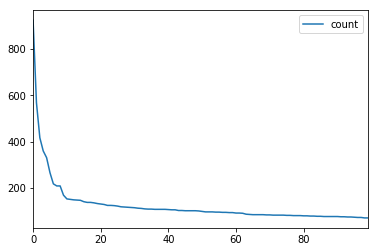

In [8]:
import matplotlib.pyplot as plt

# items ratings - Long Tail
exploded_ratings = users_libraries.selectExpr('user_hash_id','explode(user_library) AS item')
grouped_ratings = exploded_ratings.groupBy('item').count().selectExpr('count')
items_ratings_count_pd = grouped_ratings.sort(F.col('count').desc()).toPandas()
items_ratings_count_pd[:100].plot()
plt.show()

## c) Study the papers popularity by looking at the number or ratings each paper gets. For that, calculate and plot the (items, number of ratings) histogram, do you notice a long tail here as well?

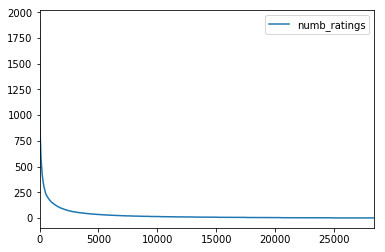

In [9]:
import matplotlib.pyplot as plt

# convert to pandas and plot
ratings_count_pd =ratings_count.selectExpr('user_hash_id', 'numb_ratings').sort(F.col('numb_ratings').desc()).toPandas()
ratings_count_pd.plot()
# users ratings
plt.show()

# Exercise 2. 2 (Rating matrix preparation, 10 points)
Write a python program that uses spark to load users ratings from the file (users libraries.txt) into a
DataFrame with the following columns:
 user id: a unique positive integer id for each user
 paper id: a unique positive integer id for each item
 rating: an integer value, you can use 1.

In [31]:
from pyspark.sql.functions import lit
import ctypes
import sys


# Convert string keys into int
## Map user_hash to integer ids, produce a lookup table
user_hashs = users_libraries.select("user_hash_id").distinct()
user_hash_id_LUT = sqlContext.createDataFrame(user_hashs.rdd.map(lambda x: x[0]).zipWithIndex(), StructType([StructField("user_hash_id", StringType(), True),StructField("user_id", IntegerType(), True)]))

## Replace user_hash_id with user_id:
users_libraries_with_ids = users_libraries.join(user_hash_id_LUT, users_libraries.user_hash_id == user_hash_id_LUT.user_hash_id).select('user_id','user_library')
"""
    The following commented code doesn't work because monotonically_increasing_id generates 64 bits numbers that use some of the first bits to indicate
    the partition that produced them, so when there is more than one partition they are too big for ALS.
    
from pyspark.sql.functions import monotonically_increasing_id
user_hashs = users_libraries.selectExpr("user_hash_id", "user_library", "row_number AS id")
users_libraries_with_ids = user_hashs#.withColumn("id", monotonically_increasing_id())
"""
ratingsRDD = users_libraries_with_ids.rdd

# Generate ratings (user_id, item_id,rating)
ratings = users_libraries_with_ids.selectExpr('user_id','explode(user_library) AS item_id')
ratings = ratings.withColumn('rating', lit(1))

In [32]:
from random import randint
def generate_negatives(positives, max_size):
    negatives = set()
    while len(negatives) < len(positives):
        candidate = randint(0, max_size)
        if candidate not in positives:
            negatives.add(candidate)
    return list(negatives)

# add the negative ratings
ratingsRDD = users_libraries_with_ids.rdd
ratingsRDD = ratingsRDD.map(lambda x: (x[0], x[1], generate_negatives(x[1], num_items)))
positive_ratings = ratingsRDD.toDF().selectExpr('_1 AS user_id','explode(_2) AS item_id').withColumn('rating', lit(1))
negative_ratings = ratingsRDD.toDF().selectExpr('_1 AS user_id','explode(_3) AS item_id').withColumn('rating', lit(0))
ratings = positive_ratings.union(negative_ratings)

# Exercise 2. 3 (ALS algorithm, 10 points)
Familiarize your self with the usage of the ALS algorithm provided by the MLlib spark library. Understand
how to invoke it and the meaning of expected parameters. Then, write a python program that
employs ALS to fit a model from the dataframe you generated in the last task. Use the learned model to
generate top 10 recommendations for all users

In [16]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Configure als
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
#TODO: add the rank parameter
als = ALS(maxIter = 2, rank = 20, regParam = 0.01,  userCol = 'user_id', itemCol ='item_id', ratingCol = 'rating', coldStartStrategy='drop')

# fit the model
model = als.fit(ratings)

# Top 10 recommendations for each user:
usersRecommendations = model.recommendForAllUsers(10)

# Top 10 users for each paper:
paperRecommandations = model.recommendForAllItems(10)


In [33]:
usersRecommendations.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    148|[[2439228,1.09836...|
|    463|[[147383,2.029003...|
|    471|[[740823,1.115332...|
|    496|[[2932527,1.54075...|
|    833|[[94154,1.7750247...|
|   1088|[[87092,2.3182065...|
|   1238|[[2771903,1.94381...|
|   1342|[[10159910,2.0777...|
|   1580|[[6807625,1.68559...|
|   1591|[[484544,1.174334...|
|   1645|[[694959,1.044573...|
|   1829|[[347175,2.108598...|
|   1959|[[282193,3.012484...|
|   2122|[[1968054,2.19017...|
|   2142|[[9951911,2.29590...|
|   2366|[[2759277,1.80345...|
|   2659|[[791438,2.516356...|
|   2866|[[467090,1.855979...|
|   3175|[[1903955,1.53665...|
|   3749|[[527168,1.580071...|
+-------+--------------------+
only showing top 20 rows



In [34]:
# user_id of  1eac022a97d683eace8815545ce3153f
user_x_id = user_hash_id_LUT.filter(user_hash_id_LUT.user_hash_id == '1eac022a97d683eace8815545ce3153f').select('user_id').collect()[0]['user_id']

usersRecommendations.filter(usersRecommendations.user_id == user_x_id).collect()

[Row(user_id=15944, recommendations=[Row(item_id=105644, rating=2.867452621459961), Row(item_id=148944, rating=2.464580535888672), Row(item_id=2767438, rating=2.3786861896514893), Row(item_id=1019882, rating=2.3689022064208984), Row(item_id=258848, rating=2.315666437149048), Row(item_id=1982489, rating=2.2998735904693604), Row(item_id=239670, rating=2.292539358139038), Row(item_id=1270989, rating=2.2373573780059814), Row(item_id=1117506, rating=2.2366116046905518), Row(item_id=3829977, rating=2.234501838684082)])]

# Exercise 2. 4 (Recommender system Evaluation, 10 points)
Spark MLlib provides functionality for evaluating machine learning algorithms. Write the python program
that uses spark to evaluate your ALS-base recommender that you built in the previous task on a
held-out test data following the following steps:

## a) Split the rating matrix into two sets: training set (contains 70% of the ratings) and test set (with 30%of the ratings)

In [36]:
training, test = ratings.randomSplit([0.7,0.3])

## b) Fit a model on the training set.

In [37]:
model = als.fit(training)

## c) Calculate the Root Mean Squared Error (RMSE) over the test set.

In [38]:
# Evaluate based on RMSE:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")
rmse = evaluator.evaluate(predictions)
print("RMSE = {}".format(rmse))

RMSE = 0.3701241122812283


## d) Generate top 10 recommendations over the test set.

In [39]:
# a) learned model over the test set -> predictions from previous cell
# b) For each user, order the papers by the predicted ratings descendingly.
# c) Choose the top 10 papers to be the recommendations for that user.
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

window = Window.partitionBy(predictions['user_id']).orderBy(predictions['prediction'].desc())

top10Predictions = predictions.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 10)

print("Top 10 recommendations for each user based on the predictions of the test dataset:")
top10Predictions.show()

Top 10 recommendations for each user based on the predictions of the test dataset:
+-------+-------+------+----------+----+
|user_id|item_id|rating|prediction|rank|
+-------+-------+------+----------+----+
|     26|3468922|     1| 1.0610949|   1|
|     26|6864015|     1|0.77888405|   2|
|     26| 845121|     1| 0.6822828|   3|
|     26|6806660|     1|0.65059996|   4|
|     26|6563754|     1|0.53402793|   5|
|     26|5489845|     1|0.51439255|   6|
|     26| 989887|     1| 0.5112466|   7|
|     26|1693077|     1| 0.5084427|   8|
|     26|4267226|     1|0.46791676|   9|
|     26|2729436|     1|0.40642715|  10|
|     29|2341475|     1|0.95613927|   1|
|     29|2353399|     1| 0.8916104|   2|
|     29|1376607|     1| 0.8763686|   3|
|     29|2353164|     1| 0.8462488|   4|
|     29|3048710|     1|0.47668642|   5|
|     29| 950558|     1|0.32409856|   6|
|     29| 514565|     1|0.31706372|   7|
|     29|2882226|     1|0.28870162|   8|
|     29|7415951|     1| 0.1830913|   9|
|     29|537505

# Exercise 2. 5 (Hyperparameter tuning, 10 points)


### Important parameters:
+ <b>rank</b>: is the number of features to use (also referred to as the number of latent factors).
+ <b>maxIter</b>: iterations is the number of iterations of ALS to run.
+ <b>regParam</b>: specifies the regularization parameter in ALS.

In [43]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml import Pipeline

evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")
als = ALS(maxIter = 2, rank = 20, regParam = 0.01,  userCol = 'user_id', itemCol ='item_id', ratingCol = 'rating', coldStartStrategy='drop')

params = ParamGridBuilder() \
    .baseOn([als.predictionCol, 'prediction']) \
    .addGrid(als.rank, [10, 25, 50]) \
    .build()
#.addGrid(als.regParam, [0.01 * i for i in range(1,100)]) \
    #.addGrid(als.maxIter, [1, 2, 3, 4]) \
cv= CrossValidator(estimator=als, estimatorParamMaps=params, evaluator=evaluator)


In [44]:
from datetime import datetime
t_initial=datetime.now()
cv_model = cv.fit(training)
time_taken=datetime.now()-t_initial
print("Time taken for the whole computation: {0} seconds ".format(str(time_taken.seconds)))

Time taken for the whole computation: 283 seconds 


In [45]:
best_model = cv_model.bestModel
print("The best model is for the value of rank:", best_model.rank)
prediction = best_model.transform(test)
rmse = evaluator.evaluate(prediction)
print("The RMSE value for the selected model is:", rmse)

The best model is for the value of rank: 50
The RMSE value for the selected model is: 0.5877320574382847


## Try to increase the maxIter, do you get better results? Report your observation.
### The results after increasing the maxIter parameter did not get any better.


## OLD d) For each of the following metrics, write one function that calculates the metric’s value. The metrics should report the average value over all users:

\begin{align}
Recall@k = \frac{1}{\text{Number of Users}}\ \sum_{u \in users} \frac{\text{Number of papers the user u likes in top k}}{\text{Total number of papers the user u likes}}\
\end{align}

In [ ]:
# users_ratings - each row [user_id, user_library = [,,,]]
# top_k_recommendations - each row [user_id, top_recommended_items = [,,,,]]

def recall_k(users_ratings, top_k_recommendations):
    total_number_of_users = users_ratings.count()
    # user_id, count of liked papers per user
    total_number_of_papers_per_user = users_ratings.select(users_ratings.user_id, F.size(users_ratings.user_library).alias("liked_papers_count")) 
    
    # user_id, top_recommended_items, user_library
    recommendations_ratings = top_k_recommendations.join(users_ratings, top_k_recommendations.user_id == users_ratings.user_id)\
        .select(top_k_recommendations.user_id, top_k_recommendations.top_recommended_items, users_ratings.user_library) 

    liked_papers_in_top_k_schema = StructType([
        #  name, dataType, nullable
        StructField("user_id", IntegerType(), False),
        StructField("papers_count", IntegerType(), False),
    ])
    # user_id, count of papers the user u likes in top k
    #TODO: check len(set)
    
    liked_papers_in_top_k_per_user = recommendations_ratings.rdd.map(lambda row: (row[0], len(set(row[1]) & set(row[2])))).toDF(liked_papers_in_top_k_schema)
    #TODO: unneded join - replace with add len(row[1]) to the previous RDD
    recallDF = liked_papers_in_top_k_per_user.join(total_number_of_papers_per_user, liked_papers_in_top_k_per_user.user_id == total_number_of_papers_per_user.user_id)\
        .select(liked_papers_in_top_k_per_user.papers_count, total_number_of_papers_per_user.liked_papers_count)
    sum_over_all_users = recallDF.rdd.map(lambda row : (row[0] / row[1])).sum()
    return (1 / total_number_of_users) * sum_over_all_users


\begin{align}
MRR@k = \frac{1}{\text{Number of Users}}\ \sum_{u \in users} \frac{1}{p_u}\
\end{align}
Where $p_u$ is the position of the first hit in the list of top k recommended papers. For example: given
the user’s u library: $\{$ 7, 12, 19, 66, 10 $\}$ assume the algorithm produces the following top 10 items
ids as recommendation for user u: $\{$ 3, 4, 5, 7, 12, 43, 2, 10, 66, 19$\}$. Then: $p_u$ = 4

In [ ]:
# TODO add comments

# TODO ask about if no common elements
def one_over_first_common_element_index(searched_array, searching_array):
    set_searched = set(searched_array)
    first_commom_element = next((a for a in searching_array if a in set_searched), -1) 
    if first_commom_element ==  -1:
        return 0
    else:
        return (1/(searched_array.index(first_commom_element) + 1))
    
def mrr_k(users_ratings, top_k_recommendations):
    total_number_of_users = users_ratings.count()

    # top_recommended_items, user_library
    recommendations_ratings = top_k_recommendations.join(users_ratings, top_k_recommendations.user_id == \
                                               users_ratings.user_id).select(top_k_recommendations.top_recommended_items, users_ratings.user_library) 
    # 1 / p_u calculation
    sum_p_per_user = recommendations_ratings.rdd.map(lambda row: one_over_first_common_element_index(row[0], row[1])).sum()
    return (1 / total_number_of_users) * sum_p_per_user

## OLD d) e) Calculate and report:
* MRR@5 and MRR@10
* Recall@k for k [10, 20, 40, 60, 80, 100]

In [ ]:
# MRR@5 calculation

# fit the model over all data
mrr_model = als.fit(ratings) 

# [Row(user_id=148, recommendations=[Row(item_id=4044418, rating=1.5029594898223877) ...)
usersRecommendations = mrr_model.recommendForAllUsers(5)
# tranformation of user recommnedation
top_5_recommendations = usersRecommendations.selectExpr('user_id','recommendations.item_id AS top_recommended_items')

# users_libraries_with_ids - each row [user_id, user_library = [,,,]]
# top_5_recommendations - each row [user_id, top_recommended_items = [,,,,]]
mrr_5 = mrr_k(users_libraries_with_ids, top_5_recommendations)
print(mrr_5)

In [ ]:
# MRR@10 calculation

# [Row(user_id=148, recommendations=[Row(item_id=4044418, rating=1.5029594898223877) ...)
usersRecommendations = mrr_model.recommendForAllUsers(10)
# tranformation of user recommnedation
top_10_recommendations = usersRecommendations.selectExpr('user_id','recommendations.item_id AS top_recommended_items')

# users_libraries_with_ids - each row [user_id, user_library = [,,,]]
# top_5_recommendations - each row [user_id, top_recommended_items = [,,,,]]
mrr_10 = mrr_k(users_libraries_with_ids, top_10_recommendations)
print(mrr_10)

In [ ]:
# Recall@10 calculation

#TODO split training and transform test 

# fit the model over all data
recall_model = als.fit(ratings)

# [Row(user_id=148, recommendations=[Row(item_id=4044418, rating=1.5029594898223877) ...)
usersRecommendations = recall_model.recommendForAllUsers(10)

# tranformation of user recommnedation
top_10_users_recommendations = usersRecommendations.selectExpr('user_id','recommendations.item_id AS top_recommended_items')

# users_libraries_with_ids - each row [user_id, user_library = [,,,]]
# top_10_users_recommendations - each row [user_id, top_recommended_items = [,,,,]]
recall_10 = recall_k(users_libraries_with_ids, top_10_users_recommendations)
print(recall_10)

In [ ]:
recall_10.filter(F.col('paper_count') == 0).count()

In [ ]:
# Recall@20 calculation

# [Row(user_id=148, recommendations=[Row(item_id=4044418, rating=1.5029594898223877) ...)
usersRecommendations = model.recommendForAllUsers(20)

# tranformation of user recommnedation
top_20_users_recommendations = usersRecommendations.selectExpr('user_id','recommendations.item_id AS top_recommended_items')

# users_libraries_with_ids - each row [user_id, user_library = [,,,]]
# top_20_users_recommendations - each row [user_id, top_recommended_items = [,,,,]]
recall20 = recall_k(users_libraries_with_ids, top_20_users_recommendations)
print(recall20)

In [ ]:
# Recall@40 calculation

usersRecommendations = model.recommendForAllUsers(40)

# tranformation of user recommnedation
top_40_users_recommendations = usersRecommendations.selectExpr('user_id','recommendations.item_id AS top_recommended_items')

# users_libraries_with_ids - each row [user_id, user_library = [,,,]]
# top_20_users_recommendations - each row [user_id, top_recommended_items = [,,,,]]
recall40 = recall_k(users_libraries_with_ids, top_40_users_recommendations)
print(recall40)

In [ ]:
# Recall@60 calculation
usersRecommendations = model.recommendForAllUsers(60)

# tranformation of user recommnedation
top_60_users_recommendations = usersRecommendations.selectExpr('user_id','recommendations.item_id AS top_recommended_items')

# users_libraries_with_ids - each row [user_id, user_library = [,,,]]
# top_20_users_recommendations - each row [user_id, top_recommended_items = [,,,,]]
recall60 = recall_k(users_libraries_with_ids, top_60_users_recommendations)
print(recall60)

In [ ]:
# Recall@80 calculation
usersRecommendations = model.recommendForAllUsers(80)

# tranformation of user recommnedation
top_80_users_recommendations = usersRecommendations.selectExpr('user_id','recommendations.item_id AS top_recommended_items')

# users_libraries_with_ids - each row [user_id, user_library = [,,,]]
# top_20_users_recommendations - each row [user_id, top_recommended_items = [,,,,]]
recall80 = recall_k(users_libraries_with_ids, top_80_users_recommendations)
print(recall80)

In [ ]:
# Recall@100 calculation
usersRecommendations = model.recommendForAllUsers(100)

# tranformation of user recommnedation
top_100_users_recommendations = usersRecommendations.selectExpr('user_id','recommendations.item_id AS top_recommended_items')

# users_libraries_with_ids - each row [user_id, user_library = [,,,]]
# top_20_users_recommendations - each row [user_id, top_recommended_items = [,,,,]]
recall100 = recall_k(users_libraries_with_ids, top_100_users_recommendations)
print(recall100)